In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor


import discretize 
from simpeg import maps, Data
from simpeg.electromagnetics import time_domain as tdem

from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# set up models and mesh

In [31]:
sigma_overburden = 0.01
depth_overburden = 60

sigma_alteration = 0.05
thickness_alteration = 150
depth_alteration = 300

sigma_stock = 0.001
width_stock = 400
depth_stock = depth_alteration

sigma_host = 0.002

sigma_air = 1e-8

rx_times = np.logspace(np.log10(2e-5), np.log10(2e-3), 20)


In [4]:
def diffusion_distance(sigma, t):
    return 1260*np.sqrt(t/sigma)

In [6]:
diffusion_distance(sigma_host, 8e-3)

np.float64(2520.0)

In [110]:
tx_height = np.r_[30]

rx_x = (np.linspace(-700, 700, 29))
rx_y = rx_x[::2]
rx_z = tx_height
rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
# rx_x

In [111]:
rx_x

array([-700., -650., -600., -550., -500., -450., -400., -350., -300.,
       -250., -200., -150., -100.,  -50.,    0.,   50.,  100.,  150.,
        200.,  250.,  300.,  350.,  400.,  450.,  500.,  550.,  600.,
        650.,  700.])

In [112]:
rx_y

array([-700., -600., -500., -400., -300., -200., -100.,    0.,  100.,
        200.,  300.,  400.,  500.,  600.,  700.])

In [113]:
td_octree_directory = "./td-octree-mt-mill"

In [114]:

np.save(f"{td_octree_directory}/rx_locs.npy", rx_locs)
np.save(f"{td_octree_directory}/rx_times.npy", rx_times)


In [115]:
source_list = []
    
for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

survey = tdem.Survey(source_list)

In [116]:

source_list = survey.source_list

with open(f"{td_octree_directory}/survey.txt", "w") as f:
    f.write(f"N_TRX {len(source_list)}\n\n")

    for src in source_list: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]} {src.location[1]} {src.location[2]} {src.radius} 0 0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {len(rx_times)}\n")
        for t in rx_times:
            rx = src.receiver_list[0]
            f.write(f"{rx.locations[0, 0]} {rx.locations[0, 1]} {rx.locations[0, 2]} {t}\n")
        f.write("\n")
    
            

In [117]:
working_dir = td_octree_directory

In [118]:
ubc_mesh = discretize.TreeMesh.read_UBC(f"{working_dir}/octree_mesh.txt")

In [119]:
ubc_mesh

OcTreeMesh,0.03% filled
Level,Number of cells
3,304
4,1484
5,1056
6,2032
7,4798
8,17284
9,58255
10,231048
Total,316261


In [120]:
model = np.ones(ubc_mesh.n_cells)*sigma_air
model[ubc_mesh.cell_centers[:, 2] < 0] = sigma_host

# alteration
extent_alteration = width_stock/2 + thickness_alteration
inds_alteration = (
    (ubc_mesh.cell_centers[:, 0] > -extent_alteration) &
    (ubc_mesh.cell_centers[:, 0] < extent_alteration) &
    (ubc_mesh.cell_centers[:, 1] > -extent_alteration) &
    (ubc_mesh.cell_centers[:, 1] < extent_alteration) &
    (ubc_mesh.cell_centers[:, 2] > -depth_alteration) &
    (ubc_mesh.cell_centers[:, 2] < 0)
)
model[inds_alteration] = sigma_alteration

# stock 
extent_stock = width_stock/2 
inds_stock = (
    (ubc_mesh.cell_centers[:, 0] > -extent_stock) &
    (ubc_mesh.cell_centers[:, 0] < extent_stock) &
    (ubc_mesh.cell_centers[:, 1] > -extent_stock) &
    (ubc_mesh.cell_centers[:, 1] < extent_stock) &
    (ubc_mesh.cell_centers[:, 2] > -depth_stock) &
    (ubc_mesh.cell_centers[:, 2] < 0)
)
model[inds_stock] = sigma_stock

# overburden
extent_overburden = 1500 # mesh dependent
inds_overburden = (
    (ubc_mesh.cell_centers[:, 0] > -extent_overburden) &
    (ubc_mesh.cell_centers[:, 0] < extent_overburden) &
    (ubc_mesh.cell_centers[:, 1] > -extent_overburden) &
    (ubc_mesh.cell_centers[:, 1] < extent_overburden) &
    (ubc_mesh.cell_centers[:, 2] > -depth_overburden) &
    (ubc_mesh.cell_centers[:, 2] < 0)
)
model[inds_overburden] = sigma_overburden

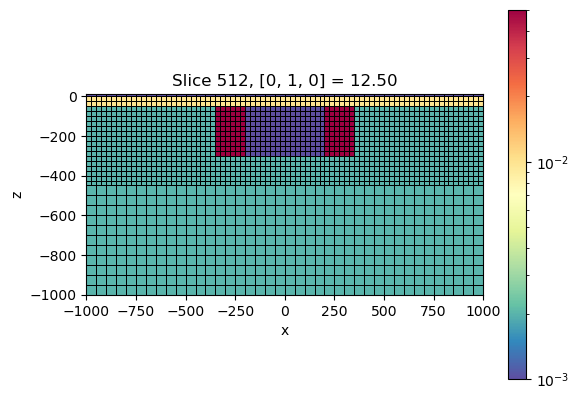

In [121]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        model,
        pcolor_opts={
            "norm":LogNorm(vmin=1e-3), "cmap":"Spectral_r"},
        grid_opts={"color":"k", "lw":0.5},
        # grid=True,
        ax=ax,
        normal="Y",
    )[0], ax=ax
)
ax.set_xlim(np.r_[-1, 1]*1000)
ax.set_ylim(np.r_[-1000, 10])
ax.set_aspect(1)

In [122]:
discretize.TreeMesh.write_model_UBC(
    ubc_mesh, f"{td_octree_directory}/model.con", 
    model
)

In [123]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }

In [124]:
len(survey.source_list)

435

In [125]:
dpred = load_pre_file(f"{td_octree_directory}/dpred-fwd.txt")

In [126]:
n_times_invert = 20

In [127]:
dpred_values = np.zeros((n_times_invert, len(dpred["transmitters"])))
for i in range(len(dpred["transmitters"])): 
    for j in range(n_times_invert): 
        dpred_values[j, i] = dpred["transmitters"][i]["receivers"][j]["data"][-1]


In [128]:
dpred_values.shape

(20, 435)

In [129]:
rx_y[7]

np.float64(0.0)

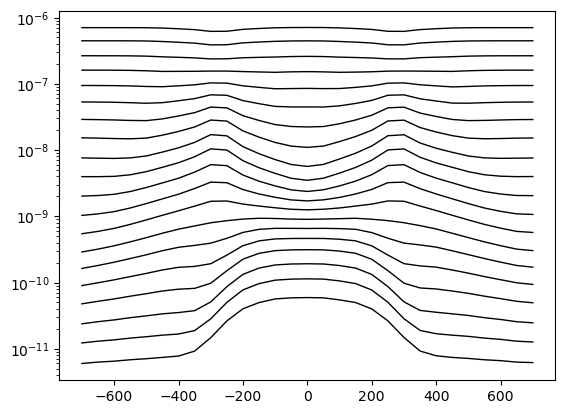

In [130]:
fig, ax = plt.subplots(1, 1)
line = 7
ax.semilogy(rx_x, dpred_values[:,line*len(rx_x):(line+1)*len(rx_x)].T, color="k", label="uniform", lw=1);

In [131]:
relative_error = 0.05
noise_floor = 1e-12

In [132]:
data_invert = Data(survey, dobs = discretize.utils.mkvc(dpred_values))

In [133]:

source_list = data_invert.survey.source_list

with open(f"{td_octree_directory}/dobs.txt", "w") as f:
    f.write(f"IGNORE -9.9999000e+004\n")
    f.write(f"N_TRX {len(source_list)}\n\n")

    for src in source_list: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]}\t{src.location[1]}\t{src.location[2]}\t{src.radius}\t0\t0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for i, t in enumerate(rx_times[:n_times_invert]):
            rx = src.receiver_list[0]
            datum = data_invert[src, rx][i]
            std = np.abs(datum) * relative_error + noise_floor
            f.write(
                f"{rx.locations[0, 0]}\t{rx.locations[0, 1]}\t{rx.locations[0, 2]}\t{t} "+
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # E data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # H data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t{datum}\t{std}\n"
            )
            
        f.write("\n")

# view inversion results

In [138]:
mrec = discretize.TreeMesh.read_model_UBC(ubc_mesh, f"{working_dir}/inv_006.con")

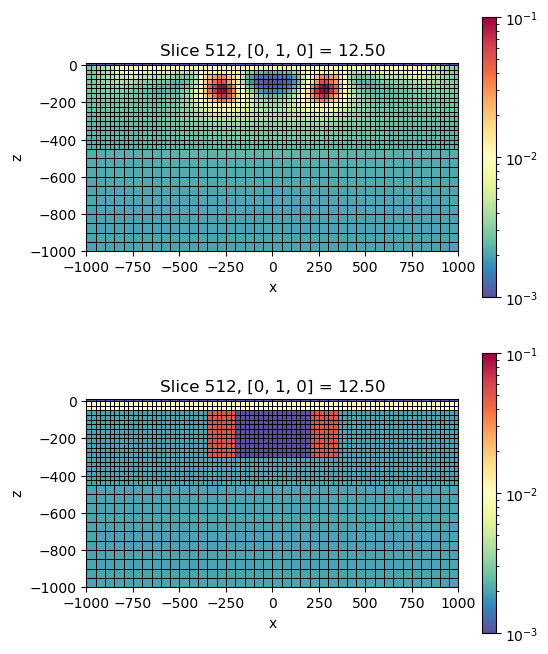

In [140]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8)) 

norm = LogNorm(vmin=1e-3, vmax=1e-1)
plt.colorbar(
    ubc_mesh.plot_slice(
        mrec,
        pcolor_opts={
            "norm":norm, "cmap":"Spectral_r"},
        grid_opts={"color":"k", "lw":0.5},
        # grid=True,
        ax=ax[0],
        normal="Y",
    )[0], ax=ax[0]
)

plt.colorbar(
    ubc_mesh.plot_slice(
        model,
        pcolor_opts={
            "norm":norm, "cmap":"Spectral_r"},
        grid_opts={"color":"k", "lw":0.5},
        # grid=True,
        ax=ax[1],
        normal="Y",
    )[0], ax=ax[1]
)

for a in ax.flatten(): 
    a.set_xlim(np.r_[-1, 1]*1000)
    a.set_ylim(np.r_[-1000, 10])
    a.set_aspect(1)

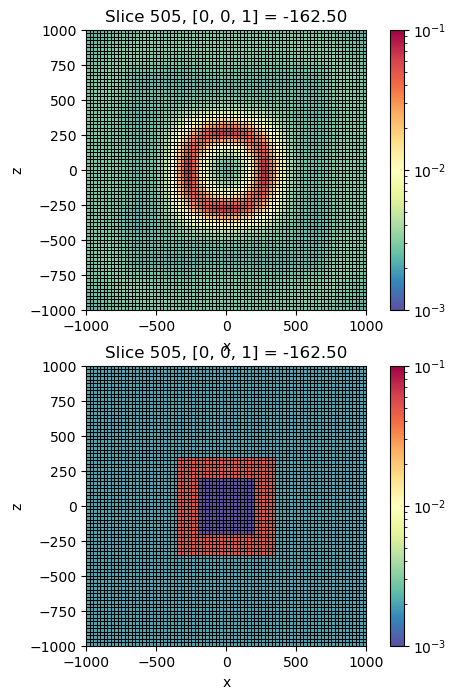

In [145]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8)) 

ind = 505
norm = LogNorm(vmin=1e-3, vmax=1e-1)
plt.colorbar(
    ubc_mesh.plot_slice(
        mrec,
        pcolor_opts={
            "norm":norm, "cmap":"Spectral_r"},
        grid_opts={"color":"k", "lw":0.5},
        # grid=True,
        ind=ind,
        ax=ax[0],
        normal="Z",
    )[0], ax=ax[0]
)

plt.colorbar(
    ubc_mesh.plot_slice(
        model,
        pcolor_opts={
            "norm":norm, "cmap":"Spectral_r"},
        grid_opts={"color":"k", "lw":0.5},
        # grid=True,
        ind=ind,
        ax=ax[1],
        normal="Z",
    )[0], ax=ax[1]
)

for a in ax.flatten(): 
    a.set_xlim(np.r_[-1, 1]*1000)
    a.set_ylim(np.r_[-1, 1]*1000)
    a.set_aspect(1)